In [34]:
import random
import time
import numpy as np
import torch
import torch.autograd
from torch.autograd import Variable
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from IPython import get_ipython
get_ipython().run_line_magic("load_ext", "autoreload")
get_ipython().run_line_magic("autoreload", "2")

from datasets import load_dataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = load_dataset("imdb")

Reusing dataset imdb (/tmp/xdg-cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


In [3]:
train_batch = dataset['train']['text']
train_labels = torch.tensor(dataset['train']['label'])

In [4]:
val_batch = dataset['test']['text']
val_labels = torch.tensor(dataset['test']['label'])

In [5]:
val_batch = val_batch[:10000]
val_labels = torch.tensor(val_labels[:10000])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [6]:
from transformers import  BartTokenizer

In [7]:
# Load the BART tokenizer.
print('Loading BART tokenizer...')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

Loading BART tokenizer...


In [8]:
vocab_size = tokenizer.vocab_size

In [9]:
seq_length = 150
input_encoding = tokenizer(train_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [10]:
val_encoding = tokenizer(val_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [11]:
input_ids = input_encoding['input_ids']
input_mask = input_encoding['attention_mask']

In [12]:
val_ids = val_encoding['input_ids']
val_mask = val_encoding['attention_mask']

In [13]:
input_ids.shape, input_mask.shape, val_ids.shape, val_mask.shape

(torch.Size([25000, 150]),
 torch.Size([25000, 150]),
 torch.Size([10000, 150]),
 torch.Size([10000, 150]))

In [14]:
# Creating DataLoaders

# TRAINNG DATALOADER
batch_size = 64

train_data = TensorDataset(input_ids, input_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [15]:
# VALIDATION DATALOADER

val_data = TensorDataset(val_ids, val_mask, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [16]:
b = next(iter(train_dataloader))

In [17]:
b[0].shape, b[1].shape, b[2].shape

(torch.Size([64, 150]), torch.Size([64, 150]), torch.Size([64]))

In [18]:
from ClassifierModel import ClassifierModel

In [19]:
clf = ClassifierModel(vocab_size, 64, 2, 2, 512, batch_size = batch_size, seq_length=seq_length)
clf

ClassifierModel(
  (embedding): Embedding()
  (lstm): LSTM(64, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=76800, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()

In [21]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [22]:
clf.to(0)

ClassifierModel(
  (embedding): Embedding()
  (lstm): LSTM(64, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=76800, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [24]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    print("Start training...\n")
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        optimizer = torch.optim.Adam(model.parameters())
        
        for step, batch in enumerate(train_dataloader):
            model.train()
            batch_counts +=1
            
            b_input_ids, b_labels = batch[0].to(0), batch[2].to(0)
            model.zero_grad()
            b_input_ids = torch.nn.functional.one_hot(b_input_ids, num_classes=vocab_size)
            if not b_input_ids.shape[0] == batch_size:
                continue

            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            train_losses.append(loss.item())
            
            preds = torch.argmax(logits, dim=1).flatten()

            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_accs.append(accuracy)
            
            
            loss.backward()

            optimizer.step()

            if (step % 20 == 0 and step != 0):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

                print("-"*70)

        if (epoch_i %20 ==0) and (epoch_i != 0):
            if evaluation == True:
                val_loss, val_accuracy = evaluate(model, val_dataloader)
                val_losses.append(val_loss)
                val_accs.append(val_accuracy)

                time_elapsed = time.time() - t0_epoch

                print(f"{epoch_i + 1:^7} | {'-':^7} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
                print("-"*70)
            print("\n")
    
    torch.save(model, 'classifier_model.pt')
    
    return  train_losses, train_accs, val_losses,val_accs

In [25]:
def evaluate(model, val_dataloader):

    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        
        b_input_ids, b_labels = batch[0].to(0), batch[2].to(0)
        b_input_ids = torch.nn.functional.one_hot(b_input_ids, num_classes=vocab_size)
        if not b_input_ids.shape[0] == batch_size:
            continue
        with torch.no_grad():
            logits = model(b_input_ids)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [26]:
train_loss = train(clf, train_dataloader, val_dataloader=val_dataloader, epochs=500, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.720548   |     -      |     -     |   2.02   
----------------------------------------------------------------------
   1    |   40    |   0.681887   |     -      |     -     |   1.83   
----------------------------------------------------------------------
   1    |   60    |   0.666727   |     -      |     -     |   1.84   
----------------------------------------------------------------------
   1    |   80    |   0.691838   |     -      |     -     |   1.84   
----------------------------------------------------------------------
   1    |   100   |   0.682719   |     -      |     -     |   1.82   
----------------------------------------------------------------------
   1    |   120   |   0.675814   |     -      |     -     |   1.84   
-----------------------------------------------------------------

   3    |   360   |   0.436040   |     -      |     -     |   1.81   
----------------------------------------------------------------------
   3    |   380   |   0.419135   |     -      |     -     |   1.83   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   4    |   20    |   0.384727   |     -      |     -     |   1.95   
----------------------------------------------------------------------
   4    |   40    |   0.346020   |     -      |     -     |   1.84   
----------------------------------------------------------------------
   4    |   60    |   0.337680   |     -      |     -     |   1.85   
----------------------------------------------------------------------
   4    |   80    |   0.361425   |     -      |     -     |   1.85   
----------------------------------------------------------------------
   4    |   1

   6    |   340   |   0.157034   |     -      |     -     |   1.86   
----------------------------------------------------------------------
   6    |   360   |   0.182185   |     -      |     -     |   1.89   
----------------------------------------------------------------------
   6    |   380   |   0.167771   |     -      |     -     |   1.87   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   7    |   20    |   0.104834   |     -      |     -     |   1.93   
----------------------------------------------------------------------
   7    |   40    |   0.107747   |     -      |     -     |   1.84   
----------------------------------------------------------------------
   7    |   60    |   0.088618   |     -      |     -     |   1.82   
----------------------------------------------------------------------
   7    |   8

   9    |   320   |   0.057870   |     -      |     -     |   1.88   
----------------------------------------------------------------------
   9    |   340   |   0.085078   |     -      |     -     |   1.89   
----------------------------------------------------------------------
   9    |   360   |   0.081532   |     -      |     -     |   1.87   
----------------------------------------------------------------------
   9    |   380   |   0.080804   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  10    |   20    |   0.055368   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  10    |   40    |   0.059106   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  10    |   6

  12    |   300   |   0.042378   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  12    |   320   |   0.048425   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  12    |   340   |   0.062794   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  12    |   360   |   0.059586   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  12    |   380   |   0.044695   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  13    |   20    |   0.035128   |     -      |     -     |   1.92   
----------------------------------------------------------------------
  13    |   4

  15    |   280   |   0.029865   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  15    |   300   |   0.068235   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  15    |   320   |   0.071285   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  15    |   340   |   0.036441   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  15    |   360   |   0.044903   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  15    |   380   |   0.050371   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  16    |   2

  18    |   260   |   0.046519   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  18    |   280   |   0.016421   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  18    |   300   |   0.016424   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  18    |   320   |   0.018542   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  18    |   340   |   0.016126   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  18    |   360   |   0.028457   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  18    |   380   |   0.042119   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Ba

  21    |   240   |   0.022147   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  21    |   260   |   0.016146   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  21    |   280   |   0.038114   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  21    |   300   |   0.042071   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  21    |   320   |   0.018237   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  21    |   340   |   0.021728   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  21    |   360   |   0.018261   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  21    |   3

  24    |   200   |   0.018542   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  24    |   220   |   0.017520   |     -      |     -     |   1.77   
----------------------------------------------------------------------
  24    |   240   |   0.009119   |     -      |     -     |   1.77   
----------------------------------------------------------------------
  24    |   260   |   0.016502   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  24    |   280   |   0.010263   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  24    |   300   |   0.019144   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  24    |   320   |   0.027364   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  24    |   3

  27    |   180   |   0.013301   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  27    |   200   |   0.018533   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  27    |   220   |   0.027803   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  27    |   240   |   0.027373   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  27    |   260   |   0.008638   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  27    |   280   |   0.021781   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  27    |   300   |   0.020420   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  27    |   3

  30    |   160   |   0.013574   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  30    |   180   |   0.005745   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  30    |   200   |   0.007147   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  30    |   220   |   0.024763   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  30    |   240   |   0.016287   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  30    |   260   |   0.015713   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  30    |   280   |   0.018804   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  30    |   3

  33    |   140   |   0.017288   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  33    |   160   |   0.017892   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  33    |   180   |   0.018801   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  33    |   200   |   0.017562   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  33    |   220   |   0.015377   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  33    |   240   |   0.021132   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  33    |   260   |   0.016974   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  33    |   2

  36    |   120   |   0.023463   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  36    |   140   |   0.023124   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  36    |   160   |   0.019152   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  36    |   180   |   0.010715   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  36    |   200   |   0.013668   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  36    |   220   |   0.021141   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  36    |   240   |   0.019452   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  36    |   2

  39    |   100   |   0.023532   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  39    |   120   |   0.023435   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  39    |   140   |   0.004320   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  39    |   160   |   0.010693   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  39    |   180   |   0.045061   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  39    |   200   |   0.013554   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  39    |   220   |   0.012972   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  39    |   2

  42    |   60    |   0.014612   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  42    |   80    |   0.007194   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  42    |   100   |   0.013254   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  42    |   120   |   0.012673   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  42    |   140   |   0.024158   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  42    |   160   |   0.014285   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  42    |   180   |   0.012606   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  42    |   2

  45    |   40    |   0.002645   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  45    |   60    |   0.008508   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  45    |   80    |   0.005029   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  45    |   100   |   0.015465   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  45    |   120   |   0.004938   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  45    |   140   |   0.005071   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  45    |   160   |   0.003180   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  45    |   1

  48    |   20    |   0.022932   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  48    |   40    |   0.027267   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  48    |   60    |   0.021569   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  48    |   80    |   0.009250   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  48    |   100   |   0.003031   |     -      |     -     |   1.90   
----------------------------------------------------------------------
  48    |   120   |   0.013298   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  48    |   140   |   0.013143   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  48    |   1

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  51    |   20    |   0.012088   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  51    |   40    |   0.015195   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  51    |   60    |   0.010522   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  51    |   80    |   0.010180   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  51    |   100   |   0.002181   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  51    |   120   |   0.023980   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  51    |   1

  53    |   380   |   0.010370   |     -      |     -     |   1.88   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  54    |   20    |   0.005358   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  54    |   40    |   0.011192   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  54    |   60    |   0.003178   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  54    |   80    |   0.003650   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  54    |   100   |   0.008480   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  54    |   1

  56    |   360   |   0.023291   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  56    |   380   |   0.012689   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  57    |   20    |   0.017361   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  57    |   40    |   0.002336   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  57    |   60    |   0.006132   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  57    |   80    |   0.010338   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  57    |   1

  59    |   340   |   0.011485   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  59    |   360   |   0.013011   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  59    |   380   |   0.011403   |     -      |     -     |   1.87   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  60    |   20    |   0.005977   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  60    |   40    |   0.010666   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  60    |   60    |   0.005500   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  60    |   8

  62    |   300   |   0.002789   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  62    |   320   |   0.029502   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  62    |   340   |   0.021157   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  62    |   360   |   0.016372   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  62    |   380   |   0.014038   |     -      |     -     |   1.80   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  63    |   20    |   0.004439   |     -      |     -     |   1.92   
----------------------------------------------------------------------
  63    |   4

  65    |   280   |   0.013025   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  65    |   300   |   0.015635   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  65    |   320   |   0.019769   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  65    |   340   |   0.012110   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  65    |   360   |   0.007870   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  65    |   380   |   0.006442   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  66    |   2

  68    |   260   |   0.004601   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  68    |   280   |   0.003410   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  68    |   300   |   0.003314   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  68    |   320   |   0.004438   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  68    |   340   |   0.005376   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  68    |   360   |   0.010780   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  68    |   380   |   0.004416   |     -      |     -     |   1.89   
----------------------------------------------------------------------
 Epoch  |  Ba

  71    |   240   |   0.008936   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  71    |   260   |   0.003464   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  71    |   280   |   0.002178   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  71    |   300   |   0.003659   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  71    |   320   |   0.006203   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  71    |   340   |   0.032203   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  71    |   360   |   0.019391   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  71    |   3

  74    |   220   |   0.008049   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  74    |   240   |   0.004350   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  74    |   260   |   0.001658   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  74    |   280   |   0.012607   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  74    |   300   |   0.014243   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  74    |   320   |   0.013690   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  74    |   340   |   0.011487   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  74    |   3

  77    |   200   |   0.011229   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  77    |   220   |   0.005865   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  77    |   240   |   0.007186   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  77    |   260   |   0.021662   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  77    |   280   |   0.003182   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  77    |   300   |   0.011305   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  77    |   320   |   0.008126   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  77    |   3

  80    |   180   |   0.004044   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  80    |   200   |   0.006028   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  80    |   220   |   0.003535   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  80    |   240   |   0.017181   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  80    |   260   |   0.011608   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  80    |   280   |   0.009392   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  80    |   300   |   0.012160   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  80    |   3

  83    |   140   |   0.008894   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  83    |   160   |   0.005405   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  83    |   180   |   0.005914   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  83    |   200   |   0.013159   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  83    |   220   |   0.023728   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  83    |   240   |   0.010012   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  83    |   260   |   0.001551   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  83    |   2

  86    |   120   |   0.011136   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  86    |   140   |   0.004916   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  86    |   160   |   0.023198   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  86    |   180   |   0.010819   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  86    |   200   |   0.001837   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  86    |   220   |   0.008952   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  86    |   240   |   0.007874   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  86    |   2

  89    |   100   |   0.005021   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  89    |   120   |   0.005443   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  89    |   140   |   0.011961   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  89    |   160   |   0.045684   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  89    |   180   |   0.020204   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  89    |   200   |   0.009319   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  89    |   220   |   0.011328   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  89    |   2

  92    |   80    |   0.010852   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  92    |   100   |   0.002355   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  92    |   120   |   0.005555   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  92    |   140   |   0.009588   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  92    |   160   |   0.010062   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  92    |   180   |   0.013192   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  92    |   200   |   0.016414   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  92    |   2

  95    |   60    |   0.020107   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  95    |   80    |   0.005126   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  95    |   100   |   0.004070   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  95    |   120   |   0.006654   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  95    |   140   |   0.009144   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  95    |   160   |   0.007103   |     -      |     -     |   1.91   
----------------------------------------------------------------------
  95    |   180   |   0.011749   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  95    |   2

  98    |   40    |   0.006078   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  98    |   60    |   0.014127   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  98    |   80    |   0.017152   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  98    |   100   |   0.010331   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  98    |   120   |   0.001767   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  98    |   140   |   0.002140   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  98    |   160   |   0.003940   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  98    |   1

  101   |   20    |   0.007150   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  101   |   40    |   0.007414   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  101   |   60    |   0.007465   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  101   |   80    |   0.004653   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  101   |   100   |   0.011568   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  101   |   120   |   0.022176   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  101   |   140   |   0.004823   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  101   |   1

  103   |   380   |   0.012275   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  104   |   20    |   0.008663   |     -      |     -     |   1.93   
----------------------------------------------------------------------
  104   |   40    |   0.009744   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  104   |   60    |   0.017908   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  104   |   80    |   0.017244   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  104   |   100   |   0.002641   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  104   |   1

  106   |   360   |   0.018123   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  106   |   380   |   0.006392   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  107   |   20    |   0.014242   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  107   |   40    |   0.002449   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  107   |   60    |   0.005941   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  107   |   80    |   0.008813   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  107   |   1

  109   |   340   |   0.014731   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  109   |   360   |   0.009922   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  109   |   380   |   0.016097   |     -      |     -     |   1.88   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  110   |   20    |   0.020979   |     -      |     -     |   1.96   
----------------------------------------------------------------------
  110   |   40    |   0.005424   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  110   |   60    |   0.005729   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  110   |   8

  112   |   320   |   0.016364   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  112   |   340   |   0.009216   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  112   |   360   |   0.005706   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  112   |   380   |   0.003553   |     -      |     -     |   1.83   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  113   |   20    |   0.003171   |     -      |     -     |   1.90   
----------------------------------------------------------------------
  113   |   40    |   0.008322   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  113   |   6

  115   |   300   |   0.005547   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  115   |   320   |   0.011216   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  115   |   340   |   0.016900   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  115   |   360   |   0.010981   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  115   |   380   |   0.015123   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  116   |   20    |   0.007071   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  116   |   4

  118   |   280   |   0.016357   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  118   |   300   |   0.009744   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  118   |   320   |   0.004993   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  118   |   340   |   0.009630   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  118   |   360   |   0.021651   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  118   |   380   |   0.016423   |     -      |     -     |   1.81   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  119   |   2

  121   |   260   |   0.008527   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  121   |   280   |   0.019343   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  121   |   300   |   0.014411   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  121   |   320   |   0.013056   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  121   |   340   |   0.005539   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  121   |   360   |   0.012268   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  121   |   380   |   0.006985   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  121   |    

  124   |   220   |   0.009005   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  124   |   240   |   0.006932   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  124   |   260   |   0.011365   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  124   |   280   |   0.011032   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  124   |   300   |   0.001984   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  124   |   320   |   0.026676   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  124   |   340   |   0.018722   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  124   |   3

  127   |   200   |   0.038279   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  127   |   220   |   0.033626   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  127   |   240   |   0.014449   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  127   |   260   |   0.013664   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  127   |   280   |   0.011833   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  127   |   300   |   0.012333   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  127   |   320   |   0.007790   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  127   |   3

  130   |   180   |   0.009892   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  130   |   200   |   0.008584   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  130   |   220   |   0.007037   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  130   |   240   |   0.026856   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  130   |   260   |   0.018504   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  130   |   280   |   0.014205   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  130   |   300   |   0.004078   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  130   |   3

  133   |   160   |   0.013190   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  133   |   180   |   0.010882   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  133   |   200   |   0.038672   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  133   |   220   |   0.013479   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  133   |   240   |   0.022624   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  133   |   260   |   0.014855   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  133   |   280   |   0.023427   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  133   |   3

  136   |   140   |   0.004407   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  136   |   160   |   0.004566   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  136   |   180   |   0.006619   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  136   |   200   |   0.009223   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  136   |   220   |   0.009509   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  136   |   240   |   0.011516   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  136   |   260   |   0.016430   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  136   |   2

  139   |   120   |   0.002700   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  139   |   140   |   0.044981   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  139   |   160   |   0.009829   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  139   |   180   |   0.010206   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  139   |   200   |   0.019227   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  139   |   220   |   0.007539   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  139   |   240   |   0.010360   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  139   |   2

  142   |   80    |   0.000762   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  142   |   100   |   0.004587   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  142   |   120   |   0.019836   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  142   |   140   |   0.010887   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  142   |   160   |   0.011442   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  142   |   180   |   0.012148   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  142   |   200   |   0.012464   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  142   |   2

  145   |   60    |   0.016009   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  145   |   80    |   0.006881   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  145   |   100   |   0.023626   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  145   |   120   |   0.014682   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  145   |   140   |   0.009117   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  145   |   160   |   0.003882   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  145   |   180   |   0.024360   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  145   |   2

  148   |   40    |   0.001722   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  148   |   60    |   0.000476   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  148   |   80    |   0.005106   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  148   |   100   |   0.009710   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  148   |   120   |   0.009543   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  148   |   140   |   0.032812   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  148   |   160   |   0.005568   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  148   |   1

  151   |   20    |   0.016208   |     -      |     -     |   1.92   
----------------------------------------------------------------------
  151   |   40    |   0.001799   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  151   |   60    |   0.005923   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  151   |   80    |   0.014824   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  151   |   100   |   0.012379   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  151   |   120   |   0.003443   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  151   |   140   |   0.004511   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  151   |   1

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  154   |   20    |   0.003058   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  154   |   40    |   0.018375   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  154   |   60    |   0.017359   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  154   |   80    |   0.029772   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  154   |   100   |   0.004006   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  154   |   120   |   0.009000   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  154   |   1

  156   |   380   |   0.006823   |     -      |     -     |   1.83   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  157   |   20    |   0.011558   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  157   |   40    |   0.019898   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  157   |   60    |   0.008633   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  157   |   80    |   0.006406   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  157   |   100   |   0.012772   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  157   |   1

  159   |   360   |   0.001449   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  159   |   380   |   0.008203   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  160   |   20    |   0.022276   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  160   |   40    |   0.004045   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  160   |   60    |   0.003722   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  160   |   80    |   0.016960   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  160   |   1

  162   |   320   |   0.012285   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  162   |   340   |   0.003178   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  162   |   360   |   0.008775   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  162   |   380   |   0.016175   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  163   |   20    |   0.009303   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  163   |   40    |   0.006110   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  163   |   6

  165   |   300   |   0.006521   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  165   |   320   |   0.008287   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  165   |   340   |   0.009081   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  165   |   360   |   0.028190   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  165   |   380   |   0.009345   |     -      |     -     |   1.79   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  166   |   20    |   0.010833   |     -      |     -     |   1.93   
----------------------------------------------------------------------
  166   |   4

  168   |   280   |   0.012537   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  168   |   300   |   0.010007   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  168   |   320   |   0.018243   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  168   |   340   |   0.014628   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  168   |   360   |   0.013063   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  168   |   380   |   0.005137   |     -      |     -     |   1.82   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  169   |   2

  171   |   260   |   0.009954   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  171   |   280   |   0.004744   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  171   |   300   |   0.015488   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  171   |   320   |   0.020354   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  171   |   340   |   0.004695   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  171   |   360   |   0.011352   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  171   |   380   |   0.009393   |     -      |     -     |   1.81   
----------------------------------------------------------------------
 Epoch  |  Ba

  174   |   240   |   0.003373   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  174   |   260   |   0.006621   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  174   |   280   |   0.014372   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  174   |   300   |   0.009090   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  174   |   320   |   0.001422   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  174   |   340   |   0.015301   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  174   |   360   |   0.005722   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  174   |   3

  177   |   220   |   0.017484   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  177   |   240   |   0.010758   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  177   |   260   |   0.004706   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  177   |   280   |   0.009396   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  177   |   300   |   0.005409   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  177   |   320   |   0.004986   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  177   |   340   |   0.003564   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  177   |   3

  180   |   200   |   0.005285   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  180   |   220   |   0.008771   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  180   |   240   |   0.023892   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  180   |   260   |   0.008832   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  180   |   280   |   0.011418   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  180   |   300   |   0.014962   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  180   |   320   |   0.015056   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  180   |   3

  183   |   160   |   0.002531   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  183   |   180   |   0.028412   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  183   |   200   |   0.024580   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  183   |   220   |   0.019384   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  183   |   240   |   0.007352   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  183   |   260   |   0.002727   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  183   |   280   |   0.010087   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  183   |   3

  186   |   140   |   0.011117   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  186   |   160   |   0.002622   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  186   |   180   |   0.007370   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  186   |   200   |   0.028059   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  186   |   220   |   0.026838   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  186   |   240   |   0.014200   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  186   |   260   |   0.007057   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  186   |   2

  189   |   120   |   0.023831   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  189   |   140   |   0.013812   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  189   |   160   |   0.025088   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  189   |   180   |   0.021604   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  189   |   200   |   0.009071   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  189   |   220   |   0.011654   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  189   |   240   |   0.003630   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  189   |   2

  192   |   100   |   0.007777   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  192   |   120   |   0.005613   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  192   |   140   |   0.015813   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  192   |   160   |   0.013794   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  192   |   180   |   0.012911   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  192   |   200   |   0.009301   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  192   |   220   |   0.020091   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  192   |   2

  195   |   80    |   0.000449   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  195   |   100   |   0.010592   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  195   |   120   |   0.026443   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  195   |   140   |   0.025929   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  195   |   160   |   0.008769   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  195   |   180   |   0.010314   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  195   |   200   |   0.001634   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  195   |   2

  198   |   60    |   0.005412   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  198   |   80    |   0.030287   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  198   |   100   |   0.009409   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  198   |   120   |   0.020932   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  198   |   140   |   0.010341   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  198   |   160   |   0.008297   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  198   |   180   |   0.015453   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  198   |   2

  201   |   40    |   0.012956   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  201   |   60    |   0.018179   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  201   |   80    |   0.003651   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  201   |   100   |   0.010204   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  201   |   120   |   0.013037   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  201   |   140   |   0.023859   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  201   |   160   |   0.004830   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  201   |   1

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  204   |   20    |   0.003465   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  204   |   40    |   0.009487   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  204   |   60    |   0.010180   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  204   |   80    |   0.010601   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  204   |   100   |   0.008133   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  204   |   120   |   0.012353   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  204   |   1

  206   |   380   |   0.013134   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  207   |   20    |   0.006268   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  207   |   40    |   0.022062   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  207   |   60    |   0.005313   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  207   |   80    |   0.034354   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  207   |   100   |   0.017605   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  207   |   1

  209   |   360   |   0.003660   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  209   |   380   |   0.004569   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  210   |   20    |   0.013878   |     -      |     -     |   1.98   
----------------------------------------------------------------------
  210   |   40    |   0.005411   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  210   |   60    |   0.018102   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  210   |   80    |   0.001511   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  210   |   1

  212   |   340   |   0.015054   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  212   |   360   |   0.009556   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  212   |   380   |   0.005010   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  213   |   20    |   0.002966   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  213   |   40    |   0.001980   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  213   |   60    |   0.012765   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  213   |   8

  215   |   320   |   0.006124   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  215   |   340   |   0.003286   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  215   |   360   |   0.010632   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  215   |   380   |   0.013733   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  216   |   20    |   0.005012   |     -      |     -     |   1.92   
----------------------------------------------------------------------
  216   |   40    |   0.013270   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  216   |   6

  218   |   300   |   0.005353   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  218   |   320   |   0.011903   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  218   |   340   |   0.006848   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  218   |   360   |   0.022877   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  218   |   380   |   0.011720   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  219   |   20    |   0.012447   |     -      |     -     |   1.91   
----------------------------------------------------------------------
  219   |   4

  221   |   280   |   0.005035   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  221   |   300   |   0.018389   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  221   |   320   |   0.013918   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  221   |   340   |   0.008414   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  221   |   360   |   0.005326   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  221   |   380   |   0.004655   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  221   |    -    |  1.544100  |   80.42   |   43.61  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train

  224   |   240   |   0.011379   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  224   |   260   |   0.011652   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  224   |   280   |   0.004040   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  224   |   300   |   0.005620   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  224   |   320   |   0.006142   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  224   |   340   |   0.013511   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  224   |   360   |   0.007364   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  224   |   3

  227   |   220   |   0.002561   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  227   |   240   |   0.016786   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  227   |   260   |   0.025307   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  227   |   280   |   0.013800   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  227   |   300   |   0.010126   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  227   |   320   |   0.009851   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  227   |   340   |   0.002730   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  227   |   3

  230   |   200   |   0.007080   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  230   |   220   |   0.006995   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  230   |   240   |   0.006718   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  230   |   260   |   0.028662   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  230   |   280   |   0.013803   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  230   |   300   |   0.026384   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  230   |   320   |   0.018900   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  230   |   3

  233   |   180   |   0.020200   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  233   |   200   |   0.003705   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  233   |   220   |   0.018784   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  233   |   240   |   0.018962   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  233   |   260   |   0.005409   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  233   |   280   |   0.009234   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  233   |   300   |   0.004857   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  233   |   3

  236   |   160   |   0.001719   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  236   |   180   |   0.010699   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  236   |   200   |   0.015866   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  236   |   220   |   0.033219   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  236   |   240   |   0.008107   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  236   |   260   |   0.008160   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  236   |   280   |   0.005712   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  236   |   3

  239   |   140   |   0.007746   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  239   |   160   |   0.007673   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  239   |   180   |   0.009222   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  239   |   200   |   0.008244   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  239   |   220   |   0.003968   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  239   |   240   |   0.001416   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  239   |   260   |   0.006487   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  239   |   2

  242   |   100   |   0.006229   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  242   |   120   |   0.016254   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  242   |   140   |   0.034889   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  242   |   160   |   0.012742   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  242   |   180   |   0.017742   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  242   |   200   |   0.019257   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  242   |   220   |   0.024035   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  242   |   2

  245   |   80    |   0.008474   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  245   |   100   |   0.006867   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  245   |   120   |   0.001597   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  245   |   140   |   0.003176   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  245   |   160   |   0.009565   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  245   |   180   |   0.027502   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  245   |   200   |   0.002295   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  245   |   2

  248   |   60    |   0.005663   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  248   |   80    |   0.007595   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  248   |   100   |   0.011474   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  248   |   120   |   0.007268   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  248   |   140   |   0.010711   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  248   |   160   |   0.017060   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  248   |   180   |   0.007767   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  248   |   2

  251   |   40    |   0.005519   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  251   |   60    |   0.012704   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  251   |   80    |   0.003028   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  251   |   100   |   0.011095   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  251   |   120   |   0.005612   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  251   |   140   |   0.005358   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  251   |   160   |   0.017986   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  251   |   1

  254   |   20    |   0.009154   |     -      |     -     |   1.92   
----------------------------------------------------------------------
  254   |   40    |   0.008442   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  254   |   60    |   0.013355   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  254   |   80    |   0.001065   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  254   |   100   |   0.010018   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  254   |   120   |   0.012444   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  254   |   140   |   0.007257   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  254   |   1

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  257   |   20    |   0.008611   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  257   |   40    |   0.015451   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  257   |   60    |   0.006450   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  257   |   80    |   0.010159   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  257   |   100   |   0.005185   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  257   |   120   |   0.014424   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  257   |   1

  259   |   380   |   0.008835   |     -      |     -     |   1.87   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  260   |   20    |   0.009228   |     -      |     -     |   1.96   
----------------------------------------------------------------------
  260   |   40    |   0.007866   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  260   |   60    |   0.018578   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  260   |   80    |   0.011236   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  260   |   100   |   0.028568   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  260   |   1

  262   |   340   |   0.012315   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  262   |   360   |   0.016610   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  262   |   380   |   0.010026   |     -      |     -     |   1.79   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  263   |   20    |   0.022236   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  263   |   40    |   0.009188   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  263   |   60    |   0.002403   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  263   |   8

  265   |   320   |   0.011815   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  265   |   340   |   0.019589   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  265   |   360   |   0.009046   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  265   |   380   |   0.016269   |     -      |     -     |   1.83   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  266   |   20    |   0.009570   |     -      |     -     |   1.93   
----------------------------------------------------------------------
  266   |   40    |   0.008613   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  266   |   6

  268   |   300   |   0.009117   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  268   |   320   |   0.003102   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  268   |   340   |   0.013083   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  268   |   360   |   0.010561   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  268   |   380   |   0.005996   |     -      |     -     |   1.79   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  269   |   20    |   0.006157   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  269   |   4

  271   |   280   |   0.013020   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  271   |   300   |   0.013200   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  271   |   320   |   0.012200   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  271   |   340   |   0.016917   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  271   |   360   |   0.014791   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  271   |   380   |   0.015708   |     -      |     -     |   1.83   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  272   |   2

  274   |   260   |   0.001917   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  274   |   280   |   0.019275   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  274   |   300   |   0.003993   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  274   |   320   |   0.006161   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  274   |   340   |   0.008561   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  274   |   360   |   0.016035   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  274   |   380   |   0.017306   |     -      |     -     |   1.79   
----------------------------------------------------------------------
 Epoch  |  Ba

  277   |   240   |   0.012957   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  277   |   260   |   0.007973   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  277   |   280   |   0.002264   |     -      |     -     |   1.77   
----------------------------------------------------------------------
  277   |   300   |   0.006777   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  277   |   320   |   0.014303   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  277   |   340   |   0.030004   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  277   |   360   |   0.026022   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  277   |   3

  280   |   220   |   0.009946   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  280   |   240   |   0.008184   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  280   |   260   |   0.005297   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  280   |   280   |   0.002172   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  280   |   300   |   0.004282   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  280   |   320   |   0.005703   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  280   |   340   |   0.011205   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  280   |   3

  283   |   180   |   0.004144   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  283   |   200   |   0.016843   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  283   |   220   |   0.010515   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  283   |   240   |   0.008438   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  283   |   260   |   0.003984   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  283   |   280   |   0.003718   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  283   |   300   |   0.026218   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  283   |   3

  286   |   160   |   0.014468   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  286   |   180   |   0.009059   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  286   |   200   |   0.006041   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  286   |   220   |   0.018780   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  286   |   240   |   0.014554   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  286   |   260   |   0.006390   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  286   |   280   |   0.014416   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  286   |   3

  289   |   140   |   0.003368   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  289   |   160   |   0.009414   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  289   |   180   |   0.025031   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  289   |   200   |   0.002987   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  289   |   220   |   0.009629   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  289   |   240   |   0.016019   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  289   |   260   |   0.007658   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  289   |   2

  292   |   120   |   0.009353   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  292   |   140   |   0.006885   |     -      |     -     |   1.79   
----------------------------------------------------------------------
  292   |   160   |   0.003004   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  292   |   180   |   0.003022   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  292   |   200   |   0.002017   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  292   |   220   |   0.004059   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  292   |   240   |   0.017854   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  292   |   2

  295   |   100   |   0.006004   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  295   |   120   |   0.019219   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  295   |   140   |   0.010169   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  295   |   160   |   0.007667   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  295   |   180   |   0.009755   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  295   |   200   |   0.008190   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  295   |   220   |   0.007513   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  295   |   2

  298   |   80    |   0.006757   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  298   |   100   |   0.021372   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  298   |   120   |   0.006949   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  298   |   140   |   0.007350   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  298   |   160   |   0.003109   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  298   |   180   |   0.011095   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  298   |   200   |   0.015758   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  298   |   2

  301   |   60    |   0.027084   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  301   |   80    |   0.015063   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  301   |   100   |   0.009783   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  301   |   120   |   0.008534   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  301   |   140   |   0.008772   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  301   |   160   |   0.017564   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  301   |   180   |   0.009081   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  301   |   2

  304   |   20    |   0.003386   |     -      |     -     |   1.91   
----------------------------------------------------------------------
  304   |   40    |   0.021302   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  304   |   60    |   0.008987   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  304   |   80    |   0.014030   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  304   |   100   |   0.010881   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  304   |   120   |   0.018467   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  304   |   140   |   0.004728   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  304   |   1

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  307   |   20    |   0.003560   |     -      |     -     |   1.90   
----------------------------------------------------------------------
  307   |   40    |   0.005728   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  307   |   60    |   0.013080   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  307   |   80    |   0.014233   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  307   |   100   |   0.009401   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  307   |   120   |   0.006648   |     -      |     -     |   1.78   
----------------------------------------------------------------------
  307   |   1

  309   |   380   |   0.008115   |     -      |     -     |   1.82   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  310   |   20    |   0.013178   |     -      |     -     |   1.91   
----------------------------------------------------------------------
  310   |   40    |   0.010496   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  310   |   60    |   0.017440   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  310   |   80    |   0.004518   |     -      |     -     |   1.90   
----------------------------------------------------------------------
  310   |   100   |   0.006083   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  310   |   1

  312   |   360   |   0.006025   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  312   |   380   |   0.009639   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  313   |   20    |   0.012726   |     -      |     -     |   1.96   
----------------------------------------------------------------------
  313   |   40    |   0.008482   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  313   |   60    |   0.006580   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  313   |   80    |   0.015501   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  313   |   1

  315   |   340   |   0.008862   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  315   |   360   |   0.012325   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  315   |   380   |   0.010194   |     -      |     -     |   1.81   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  316   |   20    |   0.019562   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  316   |   40    |   0.016847   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  316   |   60    |   0.006830   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  316   |   8

  318   |   320   |   0.015120   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  318   |   340   |   0.014408   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  318   |   360   |   0.009196   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  318   |   380   |   0.022959   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  319   |   20    |   0.006578   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  319   |   40    |   0.003262   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  319   |   6

  321   |   300   |   0.007438   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  321   |   320   |   0.008997   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  321   |   340   |   0.017739   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  321   |   360   |   0.009000   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  321   |   380   |   0.015064   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  321   |    -    |  1.731117  |   80.08   |   43.32  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  322   |   20    |   0.01

  324   |   260   |   0.013522   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  324   |   280   |   0.028273   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  324   |   300   |   0.006166   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  324   |   320   |   0.008713   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  324   |   340   |   0.005242   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  324   |   360   |   0.005673   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  324   |   380   |   0.018868   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Ba

  327   |   240   |   0.009855   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  327   |   260   |   0.006964   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  327   |   280   |   0.004790   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  327   |   300   |   0.019523   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  327   |   320   |   0.019518   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  327   |   340   |   0.009039   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  327   |   360   |   0.011794   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  327   |   3

  330   |   220   |   0.031691   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  330   |   240   |   0.003883   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  330   |   260   |   0.007601   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  330   |   280   |   0.013631   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  330   |   300   |   0.007789   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  330   |   320   |   0.004176   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  330   |   340   |   0.005561   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  330   |   3

  333   |   200   |   0.008984   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  333   |   220   |   0.018045   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  333   |   240   |   0.033030   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  333   |   260   |   0.005577   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  333   |   280   |   0.021469   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  333   |   300   |   0.015338   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  333   |   320   |   0.033309   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  333   |   3

  336   |   180   |   0.005518   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  336   |   200   |   0.017937   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  336   |   220   |   0.008815   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  336   |   240   |   0.014677   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  336   |   260   |   0.007469   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  336   |   280   |   0.022367   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  336   |   300   |   0.005612   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  336   |   3

  339   |   160   |   0.005755   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  339   |   180   |   0.010992   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  339   |   200   |   0.002790   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  339   |   220   |   0.009346   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  339   |   240   |   0.015724   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  339   |   260   |   0.007555   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  339   |   280   |   0.013887   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  339   |   3

  342   |   120   |   0.015633   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  342   |   140   |   0.002465   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  342   |   160   |   0.007762   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  342   |   180   |   0.014036   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  342   |   200   |   0.021605   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  342   |   220   |   0.028347   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  342   |   240   |   0.013038   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  342   |   2

  345   |   100   |   0.016907   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  345   |   120   |   0.001696   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  345   |   140   |   0.014822   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  345   |   160   |   0.003217   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  345   |   180   |   0.003972   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  345   |   200   |   0.011603   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  345   |   220   |   0.005310   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  345   |   2

  348   |   80    |   0.023666   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  348   |   100   |   0.012665   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  348   |   120   |   0.005918   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  348   |   140   |   0.010678   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  348   |   160   |   0.016948   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  348   |   180   |   0.004812   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  348   |   200   |   0.010116   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  348   |   2

  351   |   60    |   0.001864   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  351   |   80    |   0.003350   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  351   |   100   |   0.013186   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  351   |   120   |   0.001978   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  351   |   140   |   0.005530   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  351   |   160   |   0.002581   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  351   |   180   |   0.011221   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  351   |   2

  354   |   40    |   0.005004   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  354   |   60    |   0.000637   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  354   |   80    |   0.009475   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  354   |   100   |   0.017463   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  354   |   120   |   0.020374   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  354   |   140   |   0.013776   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  354   |   160   |   0.013793   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  354   |   1

  357   |   20    |   0.003356   |     -      |     -     |   1.93   
----------------------------------------------------------------------
  357   |   40    |   0.009200   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  357   |   60    |   0.005414   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  357   |   80    |   0.021290   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  357   |   100   |   0.012343   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  357   |   120   |   0.009038   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  357   |   140   |   0.006725   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  357   |   1

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  360   |   20    |   0.009829   |     -      |     -     |   1.92   
----------------------------------------------------------------------
  360   |   40    |   0.012296   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  360   |   60    |   0.010557   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  360   |   80    |   0.014224   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  360   |   100   |   0.009550   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  360   |   120   |   0.012233   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  360   |   1

  362   |   360   |   0.002775   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  362   |   380   |   0.010692   |     -      |     -     |   1.82   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  363   |   20    |   0.011264   |     -      |     -     |   1.96   
----------------------------------------------------------------------
  363   |   40    |   0.012487   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  363   |   60    |   0.025493   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  363   |   80    |   0.004994   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  363   |   1

  365   |   340   |   0.008723   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  365   |   360   |   0.008871   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  365   |   380   |   0.007452   |     -      |     -     |   1.84   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  366   |   20    |   0.013877   |     -      |     -     |   1.96   
----------------------------------------------------------------------
  366   |   40    |   0.007301   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  366   |   60    |   0.013707   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  366   |   8

  368   |   320   |   0.006121   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  368   |   340   |   0.014818   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  368   |   360   |   0.012423   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  368   |   380   |   0.021430   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  369   |   20    |   0.015881   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  369   |   40    |   0.006443   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  369   |   6

  371   |   300   |   0.023398   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  371   |   320   |   0.006636   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  371   |   340   |   0.030185   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  371   |   360   |   0.012367   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  371   |   380   |   0.017746   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  372   |   20    |   0.004993   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  372   |   4

  374   |   280   |   0.023107   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  374   |   300   |   0.006030   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  374   |   320   |   0.006041   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  374   |   340   |   0.017412   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  374   |   360   |   0.015399   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  374   |   380   |   0.009167   |     -      |     -     |   1.82   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  375   |   2

  377   |   260   |   0.012782   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  377   |   280   |   0.008686   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  377   |   300   |   0.009690   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  377   |   320   |   0.008119   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  377   |   340   |   0.011224   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  377   |   360   |   0.004230   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  377   |   380   |   0.008755   |     -      |     -     |   1.87   
----------------------------------------------------------------------
 Epoch  |  Ba

  380   |   240   |   0.005959   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  380   |   260   |   0.004694   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  380   |   280   |   0.003347   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  380   |   300   |   0.012867   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  380   |   320   |   0.006443   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  380   |   340   |   0.004212   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  380   |   360   |   0.002005   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  380   |   3

  383   |   200   |   0.007208   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  383   |   220   |   0.027491   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  383   |   240   |   0.008321   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  383   |   260   |   0.013028   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  383   |   280   |   0.006428   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  383   |   300   |   0.013495   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  383   |   320   |   0.025691   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  383   |   3

  386   |   180   |   0.010527   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  386   |   200   |   0.034805   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  386   |   220   |   0.010872   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  386   |   240   |   0.019523   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  386   |   260   |   0.015597   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  386   |   280   |   0.007298   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  386   |   300   |   0.019722   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  386   |   3

  389   |   160   |   0.002954   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  389   |   180   |   0.016629   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  389   |   200   |   0.013829   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  389   |   220   |   0.007680   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  389   |   240   |   0.007198   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  389   |   260   |   0.014342   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  389   |   280   |   0.014983   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  389   |   3

  392   |   140   |   0.012906   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  392   |   160   |   0.003716   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  392   |   180   |   0.019101   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  392   |   200   |   0.005901   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  392   |   220   |   0.003796   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  392   |   240   |   0.011572   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  392   |   260   |   0.007420   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  392   |   2

  395   |   120   |   0.011411   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  395   |   140   |   0.017689   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  395   |   160   |   0.008964   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  395   |   180   |   0.028492   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  395   |   200   |   0.008502   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  395   |   220   |   0.004180   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  395   |   240   |   0.004216   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  395   |   2

  398   |   100   |   0.024931   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  398   |   120   |   0.011782   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  398   |   140   |   0.006920   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  398   |   160   |   0.008182   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  398   |   180   |   0.018297   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  398   |   200   |   0.008349   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  398   |   220   |   0.008572   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  398   |   2

  401   |   80    |   0.028870   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  401   |   100   |   0.009524   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  401   |   120   |   0.025094   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  401   |   140   |   0.008092   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  401   |   160   |   0.018866   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  401   |   180   |   0.009951   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  401   |   200   |   0.003959   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  401   |   2

  404   |   40    |   0.003608   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  404   |   60    |   0.005760   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  404   |   80    |   0.009437   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  404   |   100   |   0.005795   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  404   |   120   |   0.010357   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  404   |   140   |   0.016538   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  404   |   160   |   0.010921   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  404   |   1

  407   |   20    |   0.013422   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  407   |   40    |   0.007613   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  407   |   60    |   0.002891   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  407   |   80    |   0.004386   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  407   |   100   |   0.011615   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  407   |   120   |   0.012103   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  407   |   140   |   0.005307   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  407   |   1

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  410   |   20    |   0.015691   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  410   |   40    |   0.010795   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  410   |   60    |   0.008017   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  410   |   80    |   0.011214   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  410   |   100   |   0.013108   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  410   |   120   |   0.013712   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  410   |   1

  412   |   380   |   0.033663   |     -      |     -     |   1.82   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  413   |   20    |   0.008061   |     -      |     -     |   1.92   
----------------------------------------------------------------------
  413   |   40    |   0.009135   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  413   |   60    |   0.012340   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  413   |   80    |   0.008831   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  413   |   100   |   0.003941   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  413   |   1

  415   |   360   |   0.006847   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  415   |   380   |   0.009480   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  416   |   20    |   0.008464   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  416   |   40    |   0.007617   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  416   |   60    |   0.012347   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  416   |   80    |   0.018306   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  416   |   1

  418   |   340   |   0.010011   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  418   |   360   |   0.011538   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  418   |   380   |   0.006967   |     -      |     -     |   1.88   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  419   |   20    |   0.004132   |     -      |     -     |   1.98   
----------------------------------------------------------------------
  419   |   40    |   0.013648   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  419   |   60    |   0.006944   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  419   |   8

  421   |   320   |   0.012291   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  421   |   340   |   0.020085   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  421   |   360   |   0.011432   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  421   |   380   |   0.003687   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  421   |    -    |  1.155437  |   81.05   |   43.79  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  422   |   20    |   0.007192   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  422   |   40    |   0.01

  424   |   280   |   0.037661   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  424   |   300   |   0.023795   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  424   |   320   |   0.025311   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  424   |   340   |   0.011289   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  424   |   360   |   0.012871   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  424   |   380   |   0.034570   |     -      |     -     |   1.87   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  425   |   2

  427   |   260   |   0.014239   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  427   |   280   |   0.013169   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  427   |   300   |   0.003796   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  427   |   320   |   0.011233   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  427   |   340   |   0.018056   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  427   |   360   |   0.013155   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  427   |   380   |   0.013872   |     -      |     -     |   1.80   
----------------------------------------------------------------------
 Epoch  |  Ba

  430   |   240   |   0.013562   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  430   |   260   |   0.019817   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  430   |   280   |   0.008492   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  430   |   300   |   0.019699   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  430   |   320   |   0.025758   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  430   |   340   |   0.008876   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  430   |   360   |   0.011239   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  430   |   3

  433   |   220   |   0.012660   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  433   |   240   |   0.005794   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  433   |   260   |   0.015642   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  433   |   280   |   0.033654   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  433   |   300   |   0.011068   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  433   |   320   |   0.022323   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  433   |   340   |   0.013391   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  433   |   3

  436   |   200   |   0.006027   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  436   |   220   |   0.021385   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  436   |   240   |   0.013843   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  436   |   260   |   0.012760   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  436   |   280   |   0.010694   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  436   |   300   |   0.018416   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  436   |   320   |   0.007518   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  436   |   3

  439   |   180   |   0.031125   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  439   |   200   |   0.017212   |     -      |     -     |   1.81   
----------------------------------------------------------------------
  439   |   220   |   0.025376   |     -      |     -     |   1.80   
----------------------------------------------------------------------
  439   |   240   |   0.010854   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  439   |   260   |   0.005652   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  439   |   280   |   0.021528   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  439   |   300   |   0.009041   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  439   |   3

  442   |   140   |   0.008047   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  442   |   160   |   0.017566   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  442   |   180   |   0.020161   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  442   |   200   |   0.017033   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  442   |   220   |   0.024872   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  442   |   240   |   0.009388   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  442   |   260   |   0.015781   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  442   |   2

  445   |   120   |   0.012278   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  445   |   140   |   0.040930   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  445   |   160   |   0.004930   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  445   |   180   |   0.009477   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  445   |   200   |   0.009421   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  445   |   220   |   0.005727   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  445   |   240   |   0.012726   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  445   |   2

  448   |   100   |   0.005491   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  448   |   120   |   0.002146   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  448   |   140   |   0.008600   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  448   |   160   |   0.018864   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  448   |   180   |   0.025402   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  448   |   200   |   0.012870   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  448   |   220   |   0.004443   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  448   |   2

  451   |   80    |   0.007055   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  451   |   100   |   0.025271   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  451   |   120   |   0.003253   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  451   |   140   |   0.013376   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  451   |   160   |   0.010563   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  451   |   180   |   0.005768   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  451   |   200   |   0.007362   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  451   |   2

  454   |   60    |   0.008349   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  454   |   80    |   0.014478   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  454   |   100   |   0.007240   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  454   |   120   |   0.021675   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  454   |   140   |   0.022709   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  454   |   160   |   0.029218   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  454   |   180   |   0.010978   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  454   |   2

  457   |   40    |   0.013904   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  457   |   60    |   0.005597   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  457   |   80    |   0.011773   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  457   |   100   |   0.012120   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  457   |   120   |   0.014680   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  457   |   140   |   0.019930   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  457   |   160   |   0.021791   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  457   |   1

  460   |   20    |   0.020517   |     -      |     -     |   1.94   
----------------------------------------------------------------------
  460   |   40    |   0.011657   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  460   |   60    |   0.013163   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  460   |   80    |   0.004078   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  460   |   100   |   0.008212   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  460   |   120   |   0.004440   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  460   |   140   |   0.012042   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  460   |   1

  462   |   380   |   0.007502   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  463   |   20    |   0.005981   |     -      |     -     |   1.91   
----------------------------------------------------------------------
  463   |   40    |   0.009517   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  463   |   60    |   0.011017   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  463   |   80    |   0.001640   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  463   |   100   |   0.001761   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  463   |   1

  465   |   360   |   0.009630   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  465   |   380   |   0.010456   |     -      |     -     |   1.85   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  466   |   20    |   0.004768   |     -      |     -     |   1.93   
----------------------------------------------------------------------
  466   |   40    |   0.011489   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  466   |   60    |   0.022950   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  466   |   80    |   0.006591   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  466   |   1

  468   |   340   |   0.006209   |     -      |     -     |   1.91   
----------------------------------------------------------------------
  468   |   360   |   0.016806   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  468   |   380   |   0.013751   |     -      |     -     |   1.86   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  469   |   20    |   0.006880   |     -      |     -     |   1.97   
----------------------------------------------------------------------
  469   |   40    |   0.011368   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  469   |   60    |   0.001000   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  469   |   8

  471   |   320   |   0.010350   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  471   |   340   |   0.009539   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  471   |   360   |   0.022966   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  471   |   380   |   0.027569   |     -      |     -     |   1.82   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  472   |   20    |   0.009001   |     -      |     -     |   1.93   
----------------------------------------------------------------------
  472   |   40    |   0.019687   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  472   |   6

  474   |   300   |   0.011217   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  474   |   320   |   0.022510   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  474   |   340   |   0.004357   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  474   |   360   |   0.016387   |     -      |     -     |   1.82   
----------------------------------------------------------------------
  474   |   380   |   0.023040   |     -      |     -     |   1.82   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  475   |   20    |   0.010523   |     -      |     -     |   1.95   
----------------------------------------------------------------------
  475   |   4

  477   |   280   |   0.000976   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  477   |   300   |   0.009227   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  477   |   320   |   0.014391   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  477   |   340   |   0.013123   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  477   |   360   |   0.020751   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  477   |   380   |   0.013478   |     -      |     -     |   1.89   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  478   |   2

  480   |   260   |   0.003308   |     -      |     -     |   1.90   
----------------------------------------------------------------------
  480   |   280   |   0.018466   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  480   |   300   |   0.013285   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  480   |   320   |   0.009068   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  480   |   340   |   0.004936   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  480   |   360   |   0.011148   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  480   |   380   |   0.009325   |     -      |     -     |   1.87   
----------------------------------------------------------------------
 Epoch  |  Ba

  483   |   220   |   0.014906   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  483   |   240   |   0.013506   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  483   |   260   |   0.016613   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  483   |   280   |   0.012462   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  483   |   300   |   0.040657   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  483   |   320   |   0.017946   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  483   |   340   |   0.008273   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  483   |   3

  486   |   200   |   0.006668   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  486   |   220   |   0.003751   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  486   |   240   |   0.007392   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  486   |   260   |   0.013584   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  486   |   280   |   0.005675   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  486   |   300   |   0.006250   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  486   |   320   |   0.018525   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  486   |   3

  489   |   180   |   0.040876   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  489   |   200   |   0.021773   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  489   |   220   |   0.004829   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  489   |   240   |   0.013071   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  489   |   260   |   0.021965   |     -      |     -     |   1.90   
----------------------------------------------------------------------
  489   |   280   |   0.018362   |     -      |     -     |   1.90   
----------------------------------------------------------------------
  489   |   300   |   0.011865   |     -      |     -     |   1.91   
----------------------------------------------------------------------
  489   |   3

  492   |   160   |   0.011791   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  492   |   180   |   0.004530   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  492   |   200   |   0.007824   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  492   |   220   |   0.017504   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  492   |   240   |   0.007849   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  492   |   260   |   0.013093   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  492   |   280   |   0.005549   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  492   |   3

  495   |   140   |   0.013584   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  495   |   160   |   0.020288   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  495   |   180   |   0.012742   |     -      |     -     |   1.89   
----------------------------------------------------------------------
  495   |   200   |   0.011079   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  495   |   220   |   0.003415   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  495   |   240   |   0.005537   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  495   |   260   |   0.014250   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  495   |   2

  498   |   120   |   0.011698   |     -      |     -     |   1.88   
----------------------------------------------------------------------
  498   |   140   |   0.005408   |     -      |     -     |   1.86   
----------------------------------------------------------------------
  498   |   160   |   0.017382   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  498   |   180   |   0.015553   |     -      |     -     |   1.87   
----------------------------------------------------------------------
  498   |   200   |   0.006650   |     -      |     -     |   1.85   
----------------------------------------------------------------------
  498   |   220   |   0.008893   |     -      |     -     |   1.83   
----------------------------------------------------------------------
  498   |   240   |   0.009082   |     -      |     -     |   1.84   
----------------------------------------------------------------------
  498   |   2

In [32]:
train_losses, train_accs, val_losses,val_accs = train_loss

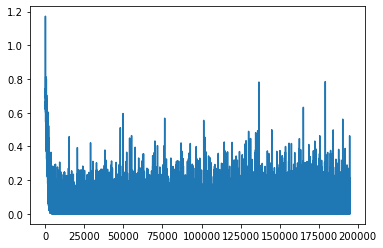

In [35]:
plt.plot(np.arange(len(train_losses)), np.array(train_losses))

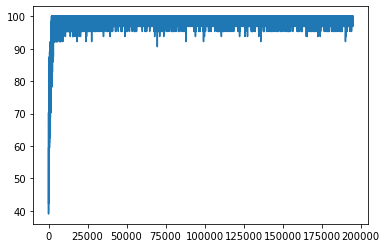

In [36]:
plt.plot(np.arange(len(train_accs)), np.array(train_accs))

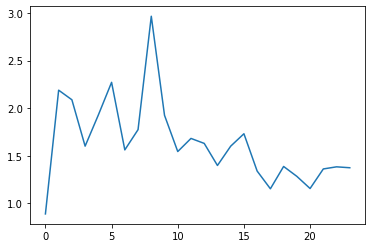

In [37]:
plt.plot(np.arange(len(val_losses)), np.array(val_losses))

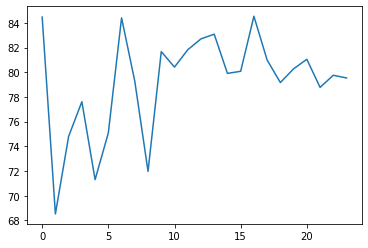

In [38]:
plt.plot(np.arange(len(val_accs)), np.array(val_accs))

# ---------- Testing differentiability ----------------

b[0].shape

b_dash = torch.randn((4,47, vocab_siz

b_dash = torch.randn((4,47, vocab_size))

a = torch.nn.Parameter(torch.zeros_like(b_dash).float() +1 )

c = 2*a

c.shape

idx =  torch.argmax(c, dim=-1, keepdims=  True)

mask = torch.zeros_like(c).scatter_(-1, idx, 1.).float().detach() + c - c.detach()

o1 = clf(mask)

mse = torch.nn.MSELoss()

z = mse(o1, torch.zeros_like(o1))

torch.autograd.grad(z, a)

# ---------------------- Fin ----------------------------